In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm

import osmnx as ox
from matplotlib import pyplot as plt
import momepy
import networkx as nx
from shapely.geometry import Polygon
import alphashape
from pyproj import Proj, Geod
import ast

data_path = '../../data/'  
polygon_road_network = gpd.read_file(data_path + 'network/QGIS_Project/referentiel-comptages-edit.shp')
paris_districts = gpd.read_file(data_path + 'districts_paris.geojson')
df_car_detectors = gpd.read_file(data_path + 'all_car_detectors.geojson')
cycleways = gpd.read_file(data_path + 'cycleways_2000-2022.geojson')

output_path = "output/"

In [2]:
## Data processing functions

def load_osm_network(year, polygon):
    if (year != 2022 or year != 2023):
        overpass_settings = '[out:json][timeout:90][date:"' + str(year) + '-01-01T00:00:00Z"]'
        print(overpass_settings)
        ox.settings.overpass_settings = overpass_settings

    ox.settings.log_console = True
    G_road_network = ox.graph_from_polygon(polygon, simplify=True, network_type="drive")
    nodes_osm, df_osm = momepy.nx_to_gdf(G_road_network, points=True, lines=True)
    df_osm['osm_id'] = range(1, len(df_osm) + 1)
    return df_osm

def filter_osm_network_for_higher_order_roads(df_osm):
    df_osm_hor = df_osm[
    df_osm["highway"].str.contains("motorway") |
    df_osm["highway"].str.contains("trunk") |
    df_osm["highway"].str.contains("primary") |
    df_osm["highway"].str.contains("secondary") |
    df_osm["highway"].str.contains("tertiary")
    ]
    df_osm_hor = df_osm_hor[df_osm_hor['geometry'].notnull()]
    return df_osm_hor

def process_car_detectors(year, polygon):
    boundary_gdf = gpd.GeoDataFrame(geometry=[polygon], crs=df_car_detectors.crs)
    # valid_detectors = df_car_detectors[(df_car_detectors['date_debut'].dt.year <= year) &  (df_car_detectors['date_fin'].dt.year >= year)]
    # df_car_detectors_without_dupl = valid_detectors.drop_duplicates(
    # subset='iu_ac', keep='first')
    car_detectors_within_boundary = gpd.sjoin(
    df_car_detectors, boundary_gdf, op='within')
    # car_detectors_within_boundary = car_detectors_within_boundary.rename(
    # columns={"iu_ac": "detector_id"})
    return car_detectors_within_boundary

def angle(geometry):
    coordinates = np.array(geometry.xy).T
    return np.arctan2(coordinates[-1, 1] - coordinates[0, 1], coordinates[-1, 0] - coordinates[0, 0])
    

## Matching functions

def prepare_scores(centroid_distances, angle_distances, alpha = 0.1, maximum_distance = 50, maximum_angle = 15 * np.pi / 180.0):
    # Prepare scoring / matching
    scores = centroid_distances + alpha * angle_distances

    # Deactivate improbable matchings
    scores[centroid_distances > maximum_distance] = np.inf
    scores[angle_distances > maximum_angle] = np.inf
    return scores

def perform_matching(scores):
    matchings = []
    matched_scores = []
    # The idea is relatively simple:
    # - Find the matching with the smallest score among those with a finite value
    # - Note down the matching, and set all matching containing the two links to Inf
    # - Continue until no scores with finite value are left
    current = np.count_nonzero(~np.isfinite(scores))
    with tqdm(total = np.prod(scores.shape) - current) as progress:
        while np.count_nonzero(np.isfinite(scores)) > 0:
        # Find best score and note down
            index = np.unravel_index(np.argmin(scores), scores.shape)
            matched_scores.append(scores[index])

        # Set both invlved links to Inf
            scores[index[0], :] = np.inf
            scores[:, index[1]] = np.inf
        
        # Manage progress plotting
            update = np.count_nonzero(~np.isfinite(scores))
        
            if update > current:
                progress.update(update - current)
                current = update

            matchings.append(index)
        
    matchings = np.array(matchings) # The matchings themselves (index detectors, index osm)
    matched_scores = np.array(matched_scores) # The scores of the matchings
    return matchings, matched_scores

def line_length_in_meters(line_string):
    # Define a UTM projection for the zone containing your coordinates
    utm_zone = 31  # Assuming you are in Paris, which falls in UTM zone 31 for example
    proj = Proj(proj='utm', zone=utm_zone, ellps='WGS84')

    # Extract coordinates from the LineString
    coordinates = list(line_string.coords)

    # Transform the coordinates to UTM projection
    utm_coordinates = [proj(lon, lat) for lon, lat in coordinates]

    # Compute the distance between consecutive points in meters
    total_length = 0
    geod = Geod(ellps='WGS84')
    for i in range(len(utm_coordinates) - 1):
        lon1, lat1 = utm_coordinates[i]
        lon2, lat2 = utm_coordinates[i + 1]
        distance_meters = geod.inv(lon1, lat1, lon2, lat2)[-1]  # Use [-1] to get distance

        # Handle case of very small distances
        if np.isnan(distance_meters):
            dx = lon2 - lon1
            dy = lat2 - lat1
            distance_meters = np.sqrt(dx**2 + dy**2)
        total_length += distance_meters

    return total_length

def is_na_list(lst):
    return lst is None or len(lst) == 0 or all(pd.isna(x) for x in lst)

def parse_and_average_lanes(lanes_str):
    if isinstance(lanes_str, list):
        if is_na_list(lanes_str):
            return np.nan
        else: 
            return sum(map(int, lanes_str)) / len(lanes_str)
    else:
        if pd.isna(lanes_str):  # Check if input is NaN
            return np.nan  # Return NaN if input is NaN
    try:
        # Attempt to parse the string as a list
        lanes_list = ast.literal_eval(lanes_str)
        if isinstance(lanes_list, list):
            # If it's a list, calculate the average of list elements
            return sum(map(int, lanes_list)) / len(lanes_list)
        else:
            # If it's a single integer, return it as is
            return int(lanes_list)
    except (SyntaxError, ValueError):
        # If parsing fails or the lanes_str is not a list, parse as single integer
        return int(lanes_str)

def approximate_number_of_lanes(df_matched):
    df_matched_with_lanes_approximated = df_matched.copy()
    average_lanes_per_highway = df_matched.groupby('highway')['lanes_mapped'].mean()
    for index, row in df_matched_with_lanes_approximated.iterrows():
        if pd.isna(row['lanes_mapped']):
            df_matched_with_lanes_approximated.at[index, 'lanes_mapped'] = average_lanes_per_highway[row['highway']]
    return df_matched_with_lanes_approximated


## Plotting functions

def plot_matching_network(df_matching, is_best, year):
    fig, ax = plt.subplots(figsize=(12,10))
    # df_osm.plot(ax=ax, color='pink', linewidth=1)

    for i in range(len(df_matching)):
        line_detector = df_matching.iloc[i]["geometry_detector"]
        x, y = line_detector.xy
        plt.plot(x,y, '-', color='yellow', linewidth=3)

        line_osm = df_matching.iloc[i]["geometry_osm"]
        x_osm, y_osm = line_osm.xy
        plt.plot(x_osm, y_osm, '-', color='blue', linewidth=1)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    if (is_best):
        plt.title("Detector and OSM road network matches (best matches) " + str(year))
    else:
        plt.title("Detector and OSM road network matches (all matches) " + str(year))
    str_best = "best" if is_best else "all"
    plt.savefig("results/detector_matches_" + str_best + "_" + str(year) + ".pdf", dpi=300)
    plt.show()

This notebook matches the links of the Paris detector network with the official cycleways noted by ParisOpenData:
- Load [official cyclways]()
- Load [detector network](https://opendata.paris.fr/explore/dataset/referentiel-comptages-routiers/information/)
- Perform matching by angle and centroid


## Load networks


In [3]:
# load OSM network
alpha_shape = alphashape.alphashape(polygon_road_network, 435)
coordinates = list(alpha_shape.exterior[0].coords)
polygon = Polygon(coordinates)

df_cycleways = cycleways
df_cycleways_red = df_cycleways[df_cycleways['typologie_simple'] == 'Pistes cyclables'] 
df_cycleways_red['cycleway_index'] = range(1, len(df_cycleways_red) + 1)

/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [4]:
df_cycleways_red.shape

(4521, 20)

## Plot data

<Axes: >

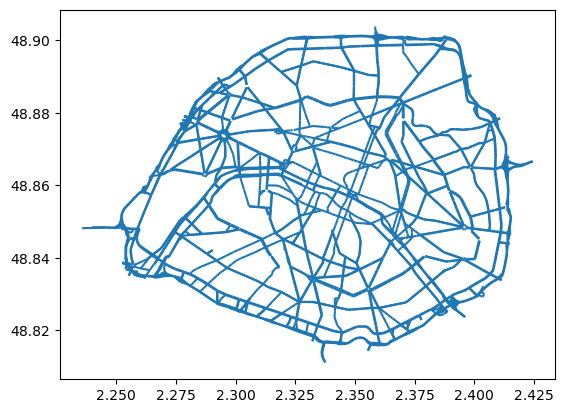

In [5]:
fig, ax = plt.subplots()
df_car_detectors.plot(ax=ax)

<Axes: >

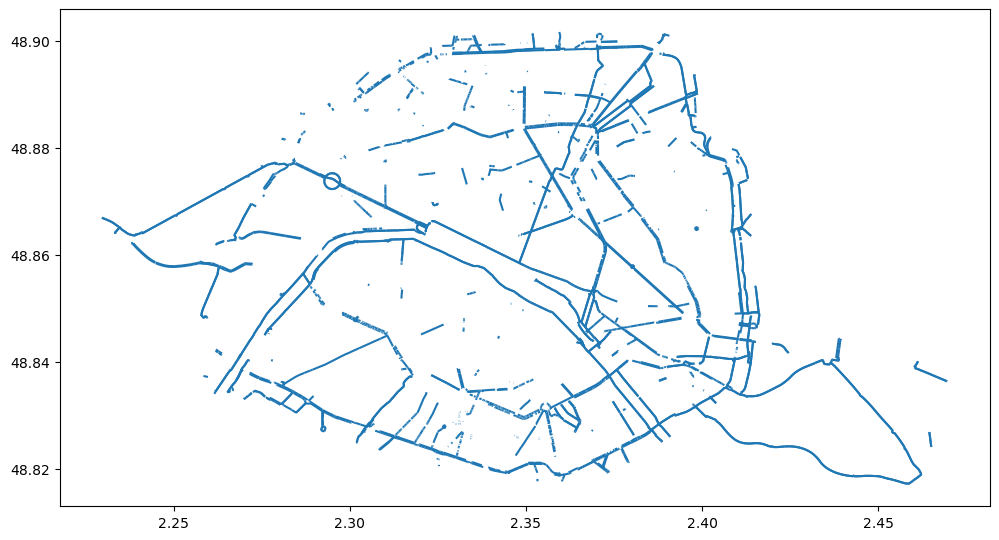

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
df_cycleways_red.plot(ax=ax)

## Matching

In [7]:
# Configure matching process

# Trade-off between scoring angle difference and centroid distance
alpha = 0.1

# Before finding the best match, we filter out unlikely matches

# Maximum centroid distance between two candidates
maximum_distance = 50

# Maximum angle difference between two candidates
maximum_angle = 15 * np.pi / 180.0

In [8]:
# Calculate centroids
detector_centroids = np.vstack([
    df_car_detectors["geometry"].centroid.x, df_car_detectors["geometry"].centroid.y]).T

cycleway_red_centroids = np.vstack([
    df_cycleways_red["geometry"].centroid.x, df_cycleways_red["geometry"].centroid.y]).T

# Calculate orientation
detector_angles = df_car_detectors["geometry"].apply(angle).values
cylceway_angles = df_cycleways_red["geometry"].apply(angle).values

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_53590/1129522494.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_car_detectors["geometry"].centroid.x, df_car_detectors["geometry"].centroid.y]).T
/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_53590/1129522494.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_cycleways_red["geometry"].centroid.x, df_cycleways_red["geometry"].centroid.y]).T


In [9]:
# Calculate n-to-m distances
centroid_distances = np.zeros((len(cycleway_red_centroids), len(detector_centroids)))
angle_distances = np.zeros((len(cylceway_angles), len(detector_angles)))

for k in tqdm(range(len(cycleway_red_centroids))):
    centroid_distances[k,:] = la.norm(cycleway_red_centroids[k] - detector_centroids, axis = 1)
    angle_distances[k,:] = np.abs(cylceway_angles[k] - detector_angles)

angle_distances[angle_distances < 0.0] += 2.0 * np.pi

  0%|          | 0/4521 [00:00<?, ?it/s]

In [11]:
scores = prepare_scores(centroid_distances, angle_distances)
matchings, matched_scores = perform_matching(scores)

  0%|          | 0/1585884 [00:00<?, ?it/s]

In [12]:
df_cycleways_red

,typologie_simple,bidirectionnel,statut,sens_velo,voie,arrdt,bois,length,longueur_du_troncon_en_km,position,circulation,piste,couloir_bus,type_continuite,reseau,date_de_livraison,geo_shape,geo_point_2d,geometry,cycleway_index
1,Pistes cyclables,Oui,VOIE 50,SENS CIRCULATION GENERALE,ALLEE DE LONGCHAMP,16.0,Bois de Boulogne,569.327362,0.569327,NaN,NaN,Niveau trottoir,NaN,NaN,REVe,2011-12-31,NaN,"{'lon': 2.2677670522287268, 'lat': 48.87361351...","LINESTRING (2.27112 48.87467, 2.27111 48.87467...",1
2,Pistes cyclables,Non,VOIE 50,SENS CIRCULATION GENERALE,BOULEVARD AUGUSTE BLANQUI,13.0,Non,46.400400,0.046400,NaN,NaN,Niveau chaussée,NaN,NaN,NaN,NaN,NaN,"{'lon': 2.3417683960097144, 'lat': 48.83140630...","LINESTRING (2.34147 48.83148, 2.34150 48.83147...",2
4,Pistes cyclables,Non,VOIE 50,CONTRESENS,BOULEVARD SAINT JACQUES,14.0,Non,36.420742,0.036421,NaN,NaN,Niveau chaussée,NaN,NaN,NaN,2014-01-06,NaN,"{'lon': 2.3405316659451483, 'lat': 48.83184518...","LINESTRING (2.34076 48.83178, 2.34031 48.83191...",3
8,Pistes cyclables,Non,VOIE 50,SENS CIRCULATION GENERALE,AVENUE DENFERT ROCHEREAU,14.0,Non,7.372720,0.007373,NaN,NaN,NaN,NaN,Traversée de carrefour,NaN,NaN,NaN,"{'lon': 2.3356967809509896, 'lat': 48.83762165...","LINESTRING (2.33567 48.83759, 2.33572 48.83765)",4
9,Pistes cyclables,Non,ZONE 30,CONTRESENS,RUE DE LA TOMBE ISSOIRE,14.0,Non,33.836394,0.033836,NaN,NaN,Niveau chaussée,NaN,NaN,NaN,NaN,NaN,"{'lon': 2.334255336762789, 'lat': 48.830476331...","LINESTRING (2.33435 48.83062, 2.33420 48.83039...",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12249,Pistes cyclables,Oui,VOIE 50,SENS CIRCULATION GENERALE,BOULEVARD D ALGERIE,19.0,Non,688.458261,0.688458,NaN,NaN,Niveau trottoir,NaN,NaN,NaN,2012-12-15,NaN,"{'lon': 2.3998883936899813, 'lat': 48.88186245...","LINESTRING (2.40163 48.87921, 2.40159 48.87922...",4517
12251,Pistes cyclables,Non,ZONE 30,CONTRESENS,RUE MARIOTTE,17.0,Non,19.771268,0.019771,NaN,NaN,Niveau chaussée,NaN,NaN,NaN,2011-12-31,NaN,"{'lon': 2.320955258870818, 'lat': 48.884126788...","LINESTRING (2.32097 48.88405, 2.32093 48.88410...",4518
12252,Pistes cyclables,Oui,VOIE 50,SENS CIRCULATION GENERALE,BOULEVARD D INDOCHINE,19.0,Non,89.062751,0.089063,NaN,NaN,Niveau trottoir,NaN,NaN,NaN,2012-12-15,NaN,"{'lon': 2.3970587199543187, 'lat': 48.88410202...","LINESTRING (2.39693 48.88449, 2.39695 48.88438...",4519
12253,Pistes cyclables,Oui,VOIE 50,SENS CIRCULATION GENERALE,AVENUE DE LA PORTE BRUNET,19.0,Non,6.269175,0.006269,NaN,NaN,NaN,NaN,Traversée de carrefour,NaN,2012-12-15,NaN,"{'lon': 2.39723593138312, 'lat': 48.8836909452...","LINESTRING (2.39725 48.88366, 2.39723 48.88372)",4520


## Output

In [13]:
len(matchings)

3724

In [14]:
def match_df(df_detectors, df_to_be_matched, matchings, matched_scores):
    matched = pd.DataFrame({
    "cycleway_index": df_to_be_matched.iloc[matchings[:,0]]["cycleway_index"].values,
    "detector_index": df_detectors.iloc[matchings[:, 1]]["iu_ac"].values,
    "geometry_cycleway": df_to_be_matched.iloc[matchings[:, 0]]["geometry"].values,
    "geometry_detector": df_detectors.iloc[matchings[:, 1]]["geometry"].values,
    "length_cycleway": df_to_be_matched.iloc[matchings[:, 0]]["length"].values,
    "date_erected": df_to_be_matched.iloc[matchings[:, 0]]["date_de_livraison"].values,
    "speed_zone": df_to_be_matched.iloc[matchings[:, 0]]["statut"].values,
    "cycleway_oneway": df_to_be_matched.iloc[matchings[:, 0]]["bidirectionnel"].values,
    "score": matched_scores
}) 
    matched = matched.sort_values(by="cycleway_index")
    # matched.rename(columns={"length": "length_mapped_osm_street"}, inplace=True)
    return matched

In [15]:
df_matched = match_df(df_car_detectors, df_cycleways_red, matchings, matched_scores)
df_matched['length_detector_street'] = df_matched['geometry_detector'].apply(lambda x: line_length_in_meters(x))
# df_matched['lanes_mapped'] = df_matched['lanes'].apply(parse_and_average_lanes)

In [16]:
df_matched

,cycleway_index,detector_index,geometry_cycleway,geometry_detector,length_cycleway,date_erected,speed_zone,cycleway_oneway,score,length_detector_street
3140,1,4463,"LINESTRING (2.27112 48.87467, 2.27111 48.87467...","LINESTRING (2.29398 48.87512, 2.29373 48.87501)",569.327362,2011-12-31,VOIE 50,Oui,0.030721,21.607023
623,2,5528,"LINESTRING (2.34147 48.83148, 2.34150 48.83147...","LINESTRING (2.33943 48.83202, 2.34094 48.83162)",46.400400,NaN,VOIE 50,Non,0.002009,118.963008
2141,3,604,"LINESTRING (2.34076 48.83178, 2.34031 48.83191...","LINESTRING (2.33495 48.84028, 2.33384 48.84064)",36.420742,2014-01-06,VOIE 50,Non,0.013201,91.191920
618,4,1835,"LINESTRING (2.33567 48.83759, 2.33572 48.83765)","LINESTRING (2.33419 48.83603, 2.33569 48.83761)",7.372720,NaN,VOIE 50,Non,0.001972,206.729648
2148,5,684,"LINESTRING (2.33435 48.83062, 2.33420 48.83039...","LINESTRING (2.32828 48.82970, 2.32700 48.82823...",33.836394,NaN,ZONE 30,Non,0.013262,231.520091
...,...,...,...,...,...,...,...,...,...,...
1060,4517,5363,"LINESTRING (2.40163 48.87921, 2.40159 48.87922...","LINESTRING (2.40113 48.88261, 2.39870 48.88450...",688.458261,2012-12-15,VOIE 50,Oui,0.004146,496.447409
2158,4518,1888,"LINESTRING (2.32097 48.88405, 2.32093 48.88410...","LINESTRING (2.32566 48.88747, 2.32601 48.88853)",19.771268,2011-12-31,ZONE 30,Non,0.013414,120.253344
1103,4519,1501,"LINESTRING (2.39693 48.88449, 2.39695 48.88438...","LINESTRING (2.39567 48.88848, 2.39619 48.88702)",89.062751,2012-12-15,VOIE 50,Oui,0.004448,166.855850
457,4520,1500,"LINESTRING (2.39725 48.88366, 2.39723 48.88372)","LINESTRING (2.39715 48.88371, 2.39685 48.88452)",6.269175,2012-12-15,VOIE 50,Oui,0.001384,93.455123


In [17]:
# df_matched_with_lanes_approximated = approximate_number_of_lanes(df_matched)

In [52]:
# filter out the matches with the highest score
df_matching_best = df_matched[df_matched['score'] < 0.05]


In [53]:
# save the results

# df_matching_best.to_csv(output_path + "best_matches_" + str(year) + ".csv", sep=";", index=False)
# df_matched_with_lanes_approximated.to_csv(output_path + "matches_" + str(year) + ".csv", sep=";", index=False)

In [54]:
# plot_matching_network(df_matched_with_lanes_approximated, is_best=False, year=year)
# plot_matching_network(df_matching_best, is_best=True, year=year)

In [55]:
print(len(df_matched))
print(len(df_matching_best))

3724
3447


In [56]:
type(df_matched)

pandas.core.frame.DataFrame

In [57]:
gdf_matched = gpd.GeoDataFrame(df_matched, geometry='geometry_detector')
gdf_matching_best = gpd.GeoDataFrame(df_matching_best, geometry='geometry_detector')

Text(0.5, 1.0, 'Cycleways in Paris')

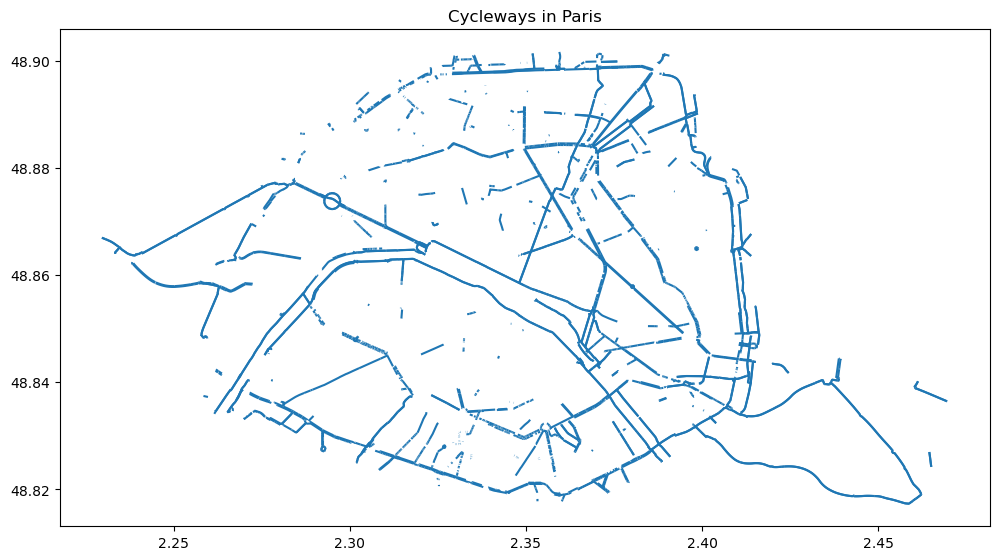

In [58]:
fig, ax = plt.subplots(figsize=(12, 10))
df_cycleways_red.plot(ax=ax)
ax.set_title("Cycleways in Paris")

Text(0.5, 1.0, 'Detectors in Paris')

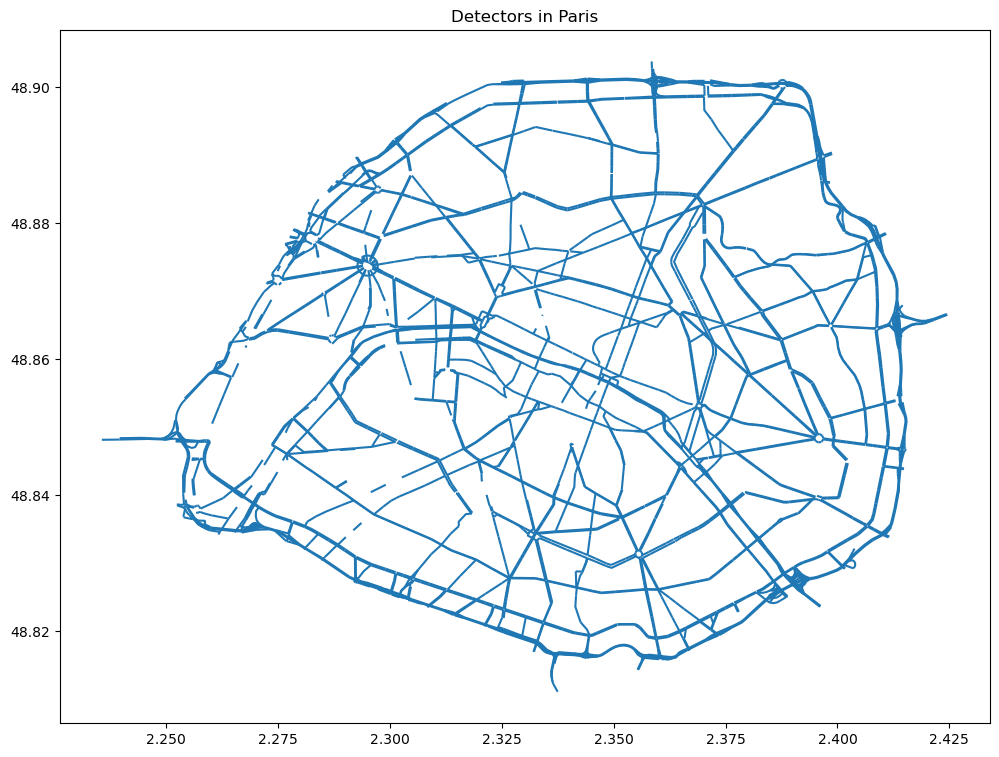

In [59]:
fig, ax = plt.subplots(figsize=(12, 10))
gdf_matching_best.plot(ax=ax)
ax.set_title("Detectors in Paris")

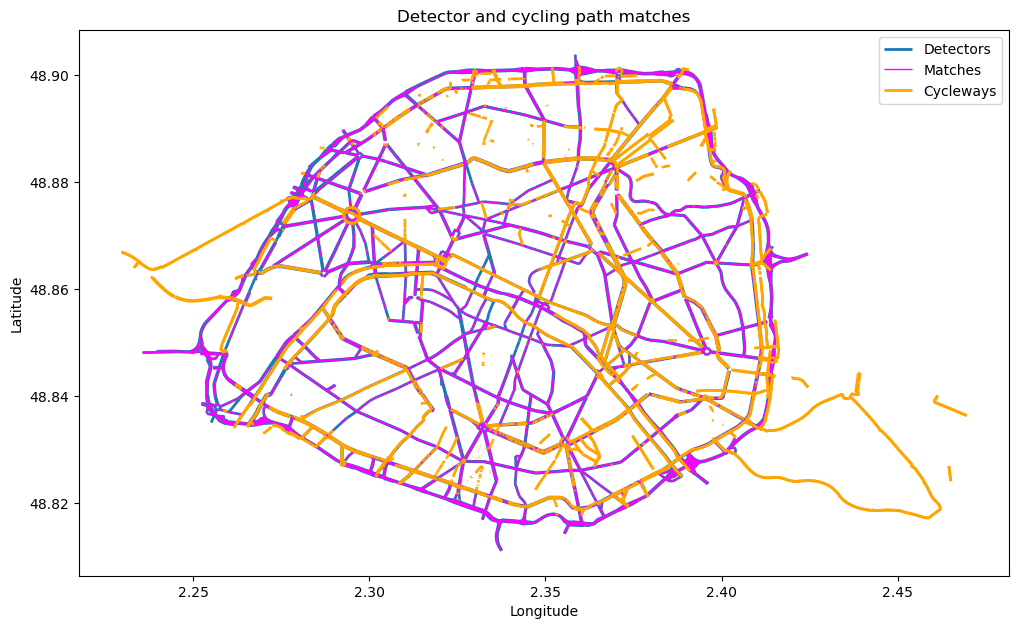

In [62]:
fig, ax = plt.subplots(figsize=(12, 10))
gdf_matched.plot(ax=ax, linewidth=2, label = "Detectors")
gdf_matching_best.plot(ax=ax, color = 'magenta', linewidth=1, label = "Matches")
df_cycleways_red.plot(ax=ax, color = 'orange', linewidth = 2, label = "Cycleways")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Detector and cycling path matches")
plt.legend()
plt.savefig("results/detector_matches_cyclepaths.pdf", dpi=1000)

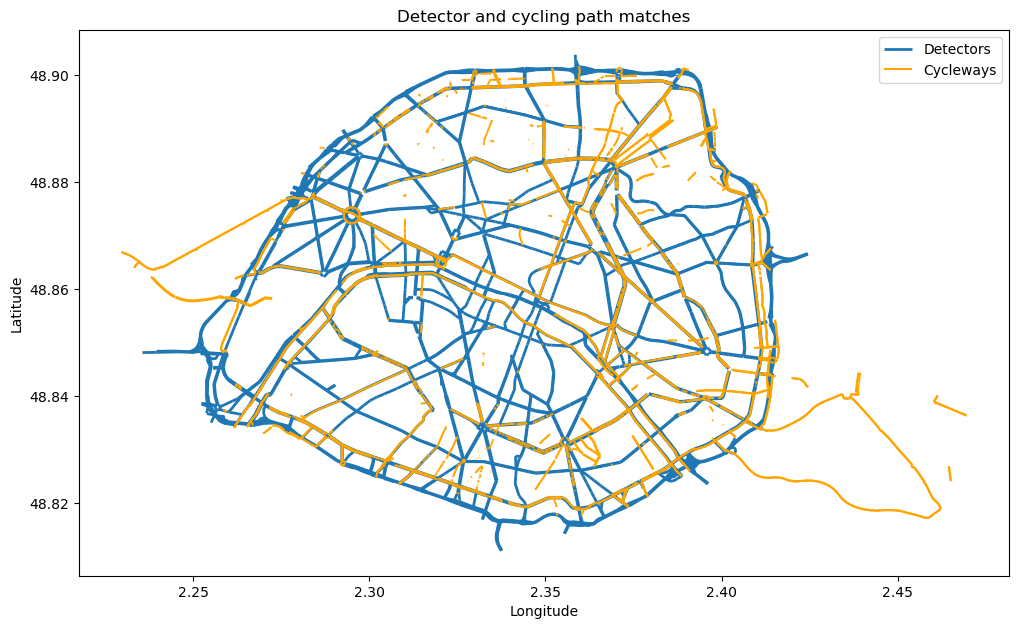

In [65]:
fig, ax = plt.subplots(figsize=(12, 10))
gdf_matched.plot(ax=ax, linewidth=2, label = "Detectors")
# gdf_matching_best.plot(ax=ax, color = 'magenta', linewidth=1, label = "Matches")
df_cycleways_red.plot(ax=ax, color = 'orange', linewidth = 1.5, label = "Cycleways")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Detector and cycling path matches")
plt.legend()
plt.savefig("results/detector_and_cyclepaths.pdf", dpi=1000)